# Interpolating Spectra Data and Fitting with DRDMannTurb

In [1]:
import numpy as np 
from pathlib import Path 
import torch 
import torch.nn as nn

from drdmannturb.calibration import CalibrationProblem
from drdmannturb.interpolation import extract_x_spectra, interp_spectra
from drdmannturb.data_generator import OnePointSpectraDataGenerator
from drdmannturb.shared.parameters import NNParameters, ProblemParameters, LossParameters, PhysicalParameters
from drdmannturb.shared.enums import DataType

import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.style.use('seaborn')

device = "cuda" if torch.cuda.is_available() else "cpu" 

# v2: torch.set_default_device('cuda:0')
if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

/tmp/ipykernel_142482/852722378.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


## Extract Data from Provided CSVs

In [2]:
# for interpolation, log10-scaled k1 is used, regular values of the domain used for fitting
x_coords_u, u_spectra = extract_x_spectra(Path().resolve() /        "../data" / "u_spectra.csv")
x_coords_v, v_spectra = extract_x_spectra(Path().resolve() /        "../data" / "v_spectra.csv")
x_coords_w, w_spectra = extract_x_spectra(Path().resolve() /        "../data" / "w_spectra.csv")
x_coords_uw, uw_cospectra = extract_x_spectra(Path().resolve() /    "../data" / "uw_cospectra.csv")


In [3]:
x_interp = np.linspace(min(x_coords_w), max(x_coords_w), 40) # all coords are on the same here, but choose bounds on the domain which are inclusive of all sampling locations

interp_u = interp_spectra(x_interp, x_coords_u, u_spectra)
interp_v = interp_spectra(x_interp,x_coords_v, v_spectra)
interp_w = interp_spectra(x_interp, x_coords_w, w_spectra)
interp_uw = interp_spectra(x_interp,x_coords_uw, uw_cospectra)

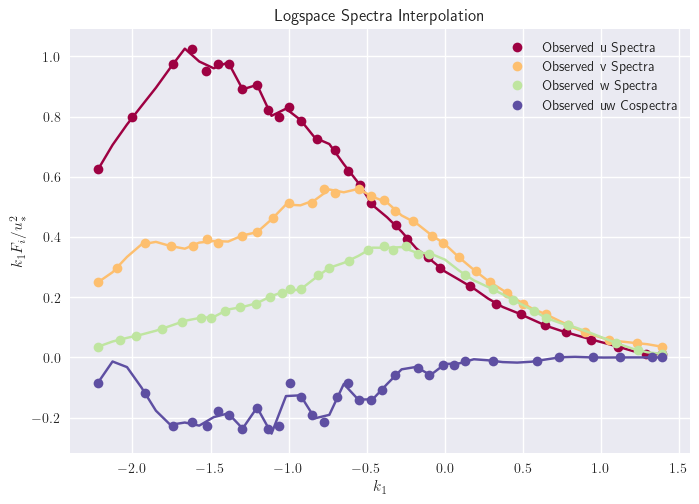

In [4]:
cmap = plt.get_cmap('Spectral', 4)
custom_palette = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

plt.plot(x_coords_u, u_spectra, "o", label="Observed u Spectra", color=custom_palette[0])
plt.plot(x_interp, interp_u, color=custom_palette[0])
plt.plot(x_coords_v, v_spectra, "o", label="Observed v Spectra", color=custom_palette[1])
plt.plot(x_interp, interp_v, color=custom_palette[1])
plt.plot(x_coords_w, w_spectra, "o", label="Observed w Spectra", color=custom_palette[2])
plt.plot(x_interp, interp_w, color=custom_palette[2])
plt.plot(x_coords_uw, uw_cospectra, "o", label="Observed uw Cospectra", color=custom_palette[3])
plt.plot(x_interp, interp_uw, color=custom_palette[3])

plt.xlabel(r"$k_1$")
plt.ylabel(r"$k_1 F_i /u_*^2$")
plt.title("Logspace Spectra Interpolation")
plt.legend()

In [5]:
L = 0.59
Gamma = 3.9
sigma = 3.2
Uref = 21.0 

domain_np = np.power(10, x_interp)
domain = torch.tensor(domain_np)

pb = CalibrationProblem(
    nn_params = NNParameters(
        activations = [nn.GELU(), nn.GELU()], 
    ),
    prob_params = ProblemParameters(nepochs=5),
    loss_params = LossParameters(),
    phys_params = PhysicalParameters(
        L=L,
        Gamma=Gamma,
        sigma=sigma,
        Uref=Uref,
        domain=domain
    ), 
    device=device
)

/home/ai/miniconda3/envs/fracturbulence/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
parameters = pb.parameters
parameters[:3] = [
    np.log(L),
    np.log(Gamma),
    np.log(sigma)
]

pb.parameters = parameters[:len(pb.parameters)]

f = domain
k1_data_pts = 2 * torch.pi * f / Uref 

DataPoints = [(k1, 1) for k1 in k1_data_pts]
spectra_values = np.stack((interp_u, interp_v, interp_w, -interp_uw), axis=1)

In [7]:
Data = OnePointSpectraDataGenerator(data_points=DataPoints, data_type=DataType.AUTO, k1_data_points=(k1_data_pts.cpu().numpy() if torch.cuda.is_available() else k1_data_pts.numpy()), spectra_values=spectra_values).Data

Filtering provided spectra interpolation: 
[fit u spectra]
---------------------
RMSE: 0.0306845781823255
R-squared: 0.9923822120712771
---------------------
[fit v spectra]
---------------------
RMSE: 0.06655568019186855
R-squared: 0.8362598440331215
---------------------
[fit w spectra]
---------------------
RMSE: 0.021661706943741213
R-squared: 0.9631571380884996
---------------------
[fit uw cospectra]
---------------------
RMSE: 0.03302925293012712
R-squared: 0.8525919464352417


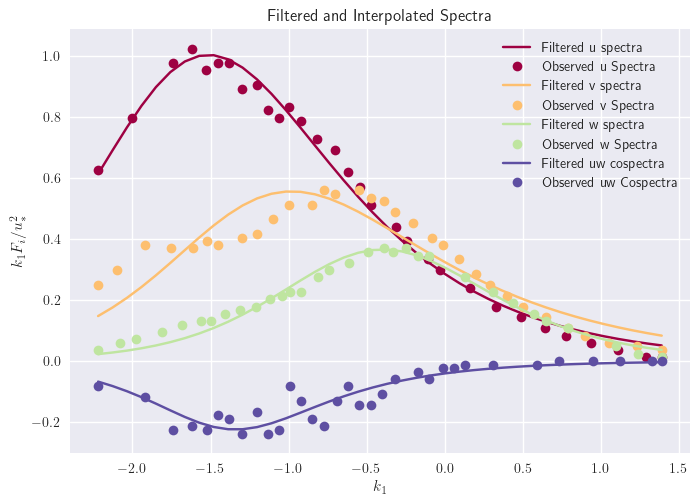

In [8]:
filtered_data_fit = Data[1].cpu().numpy() if torch.cuda.is_available() else Data[1].numpy()

plt.plot(x_interp, filtered_data_fit[:, 0, 0], label="Filtered u spectra", color=custom_palette[0])
plt.plot(x_coords_u, u_spectra, "o", label="Observed u Spectra", color=custom_palette[0])

plt.plot(x_interp, filtered_data_fit[:, 1, 1], label="Filtered v spectra", color=custom_palette[1])
plt.plot(x_coords_v, v_spectra, "o", label="Observed v Spectra", color=custom_palette[1])

plt.plot(x_interp, filtered_data_fit[:, 2, 2], label="Filtered w spectra", color=custom_palette[2])
plt.plot(x_coords_w, w_spectra, "o", label="Observed w Spectra", color=custom_palette[2])

plt.plot(x_interp, filtered_data_fit[:, 0, 2], label="Filtered uw cospectra", color=custom_palette[3])
plt.plot(x_coords_uw, uw_cospectra, "o", label="Observed uw Cospectra", color=custom_palette[3])

plt.title("Filtered and Interpolated Spectra")
plt.xlabel(r"$k_1$")
plt.ylabel(r"$k_1 F_i /u_*^2$")
plt.legend()

In [9]:
pb.eval(k1_data_pts)
pb.calibrate(data=Data)


Calibrating MannNet...
torch.Size([160])
Initial loss:  4.5242651326371

[Calibration.py -- calibrate]-> Epoch 0

loss  =  4.5242651326371
loss  =  4.43099679965019
loss  =  3.6615978653261103
loss  =  2.9680106861643925
loss  =  2.3992844718842106
loss  =  1.9688101440107602
loss  =  1.6065588678847165
loss  =  1.317447980641635
loss  =  1.0690856390017338
loss  =  0.8186302381403359
loss  =  0.6587595799811683
loss  =  0.5263656010873806
loss  =  0.25724041039371753
loss  =  0.22406304737750582
loss  =  0.21937811367046445
loss  =  0.19959484167671757
loss  =  0.19878548450121541
loss  =  0.19364843630537076
loss  =  0.19301641680030107
loss  =  0.18897880937537648
loss  =  0.18800724745795933
loss  =  0.1818332637131647
loss  =  0.18106285808299633
loss  =  0.17587057792321953
loss  =  0.1741558894698697
---------------------------------



[Calibration.py -- calibrate]-> Epoch 1

loss  =  0.1741558894698697
loss  =  0.17211446525402738
loss  =  0.16899554772839334
loss  =  0.16718

array([ 2.73678631e+00,  7.16417640e-01,  4.43548686e+00,  4.66427740e-01,
        4.46500270e-01,  2.86124792e-01, -3.59458952e-01, -3.12298356e-01,
       -5.40473521e-01, -2.91082170e-01,  3.37258690e-01,  1.11900999e-02,
       -3.78399283e-01, -3.22506518e-01, -3.24668259e-01,  4.33376725e-01,
       -5.16627884e-01,  2.55191369e-02,  1.77729862e-01, -9.09560753e-02,
        1.67374307e-01,  6.92220638e-01,  5.69046516e-01, -7.99464224e-01,
        6.28580910e-01,  3.46632330e-01, -4.46808602e-01, -5.20527437e-01,
       -6.19265196e-01,  6.06576238e-01,  4.81868418e-01,  5.36238325e-01,
        9.43930615e-01,  2.47708308e-01,  6.07302139e-02, -1.19760707e-01,
       -3.12713235e-01, -2.53793474e-01, -2.42356689e-01,  8.85586306e-02,
        4.11424950e-01,  2.39945674e-01,  3.63081281e-01,  2.59375600e-01,
       -6.56814948e-02, -2.00805111e-01, -1.84406355e-01,  8.83953792e-02,
        1.25714587e-01, -5.49498360e-01, -3.05938927e-02,  1.82028970e-02,
        5.56811700e-01,  

k1.size: torch.Size([40])   self.kF_data_vals: torch.Size([160])


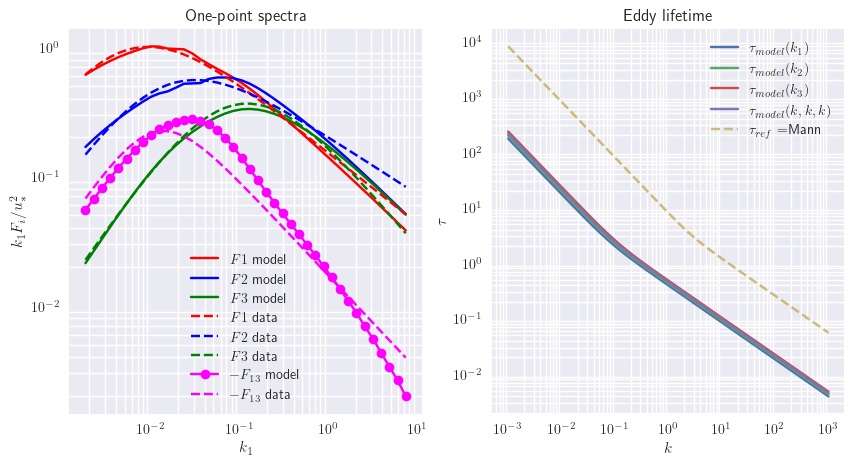

In [10]:
pb.plot(plt_dynamic=False)

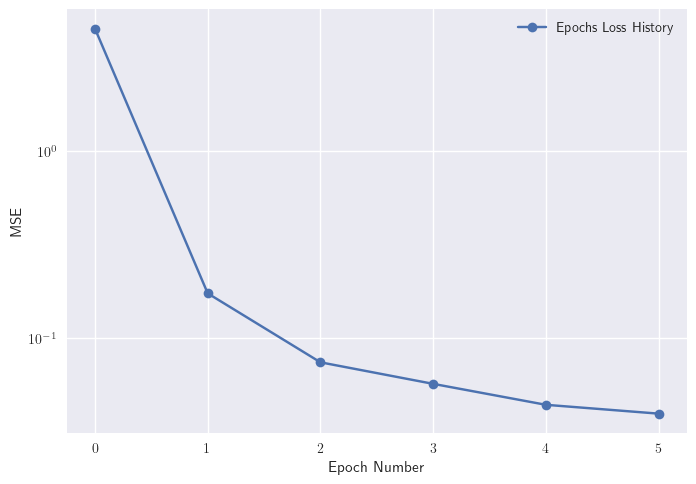

In [11]:
plt.figure()

plt.plot( pb.loss_history_epochs, 'o-', label="Epochs Loss History")
plt.legend()
plt.xlabel("Epoch Number")
plt.ylabel("MSE")
plt.yscale('log')

plt.show()